#Libraries and Data

In [1]:
#import libraries
import numpy as np
import pandas as pd
import itertools
from prophet import Prophet
import yfinance
import pickle
from ta import add_all_ta_features
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from matplotlib.pylab import rcParams
from sklearn import tree
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
#load the data

#data = yfinance.download (tickers = "TATAPOWER.NS",start="2017-03-06",
 #                              interval = "1d", group_by = 'ticker', auto_adjust = True)

#data.tail()
#["RELI","HDFCBANK.NS","TATAMOTORS.NS","SBIN.NS","TATAMOTORS.NS","TCS.NS","TITAN.NS","SUNPHARMA.BO","TECHM.NS",
# "ASIANPAINT.NS","TATACONSUM.NS"]
symbol = "^NSEI"
#["OLECTRA.NS","LT.NS","CONCOR.NS","ELGIEQUIP.NS","IOC.NS","BEL.NS","TATAELXSI.NS","^NSEI"]
data = pd.read_csv("../stock_historical_data/{}.csv".format(symbol))
data.set_index("Date", inplace=True)

In [3]:
data.index

Index(['2007-09-17', '2007-09-18', '2007-09-19', '2007-09-20', '2007-09-21',
       '2007-09-24', '2007-09-25', '2007-09-26', '2007-09-27', '2007-09-28',
       ...
       '2023-07-07', '2023-07-10', '2023-07-11', '2023-07-12', '2023-07-12',
       '2023-07-12', '2023-07-13', '2023-07-14', '2023-07-14', '2023-07-14'],
      dtype='object', name='Date', length=3883)

#Data preparation

In [4]:
#transform the date variable
data["Date"] = pd.to_datetime(data.index)


In [5]:
#renaming variables
data["y"] = data["Close"]
data = data.rename(columns = {
                     'Date': 'ds'})
data.head(10)
data = data.reset_index()

#Holidays

In [6]:
data  = add_all_ta_features(data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)


In [7]:
#create training and test set
test_days = 60
training_set = data.iloc[:-test_days,:]
test_set = data.iloc[-test_days:,:]

In [8]:
training_set

,Date,Open,High,Low,Close,Volume,ds,y,volume_adi,volume_obv,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
0,2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,0,2007-09-17,4494.649902,-0.000000e+00,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4494.649902,-50.000411,0.000000,0.000000
1,2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,0,2007-09-18,4546.200195,0.000000e+00,0,...,0.091415,0.018283,0.073132,0.000000,0.000000,0.000000,4516.715946,1.146926,1.140398,1.146926
2,2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,0,2007-09-19,4732.350098,0.000000e+00,0,...,0.490209,0.112668,0.377541,0.000000,0.000000,0.000000,4605.963404,4.094626,4.013017,5.288514
3,2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,0,2007-09-20,4747.549805,0.000000e+00,0,...,0.821073,0.254349,0.566723,0.000000,0.000000,0.000000,4664.368713,0.321187,0.320673,5.626687
4,2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,0,2007-09-21,4837.549805,0.000000e+00,0,...,1.224682,0.448416,0.776266,0.000000,0.000000,0.000000,4733.773643,1.895715,1.877970,7.629068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3818,2023-04-19,17653.349609,17666.150391,17579.849609,17618.750000,281500,2023-04-19,17618.750000,3.425443e+07,55691000,...,0.505476,0.181100,0.324376,2.198453,0.132265,2.066188,17677.796117,-0.234428,-0.234704,291.993823
3819,2023-04-20,17638.599609,17684.449219,17584.349609,17624.449219,215100,2023-04-20,17624.449219,3.421167e+07,55906100,...,0.490856,0.243051,0.247804,0.301743,0.166160,0.135582,17673.735088,0.032347,0.032342,292.120623
3820,2023-04-21,17639.750000,17663.199219,17553.949219,17624.050781,230200,2023-04-21,17624.050781,3.427689e+07,55675900,...,0.473601,0.289161,0.184440,-0.763339,-0.019740,-0.743600,17672.654467,-0.002261,-0.002261,292.111759
3821,2023-04-24,17707.550781,17754.500000,17612.500000,17743.400391,255700,2023-04-24,17743.400391,3.449262e+07,55931600,...,0.508770,0.333083,0.175687,-0.813675,-0.178527,-0.635149,17676.036596,0.677197,0.674915,294.767129


#Prophet

In [9]:
m = Prophet(
            #holidays = holidays,
            #seasonality_mode = 'multiplicative',
            #seasonality_prior_scale = 20,
           # changepoint_prior_scale = 0.1,
           # holidays_prior_scale = 10
           )
m.add_regressor('volume_adi')
m.add_regressor('volume_obv')
m.add_regressor('volume_cmf')
m.add_regressor('others_dr')
m.add_regressor('volume_adi')
m.fit(training_set)


10:09:40 - cmdstanpy - INFO - Chain [1] start processing
10:09:46 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
future = pd.DataFrame({"ds" : data.ds})

In [11]:
#forecast
forecast = m.predict(data)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3878,2023-07-12,9453.168474,18143.388435,19066.758968,9411.482166,9529.441466,9141.129899,9141.129899,9141.129899,8591.446221,...,565.728648,565.728648,565.728648,-16.044970,-16.044970,-16.044970,0.0,0.0,0.0,18594.298374
3879,2023-07-13,9453.782972,18146.964459,19074.419777,9410.510017,9536.881963,9159.452431,9159.452431,9159.452431,8593.726903,...,575.470236,575.470236,575.470236,-9.744709,-9.744709,-9.744709,0.0,0.0,0.0,18613.235403
3880,2023-07-14,9454.397471,18191.486105,19087.066530,9405.828237,9542.301282,9170.301193,9170.301193,9170.301193,8616.979401,...,556.782520,556.782520,556.782520,-3.460728,-3.460728,-3.460728,0.0,0.0,0.0,18624.698663
3881,2023-07-14,9454.397471,18204.598391,19088.267258,9401.070193,9547.860809,9205.879098,9205.879098,9205.879098,8652.557306,...,556.782520,556.782520,556.782520,-3.460728,-3.460728,-3.460728,0.0,0.0,0.0,18660.276569
3882,2023-07-14,9454.397471,18268.897923,19184.143752,9399.235091,9551.786188,9261.097257,9261.097257,9261.097257,8707.775466,...,556.782520,556.782520,556.782520,-3.460728,-3.460728,-3.460728,0.0,0.0,0.0,18715.494728


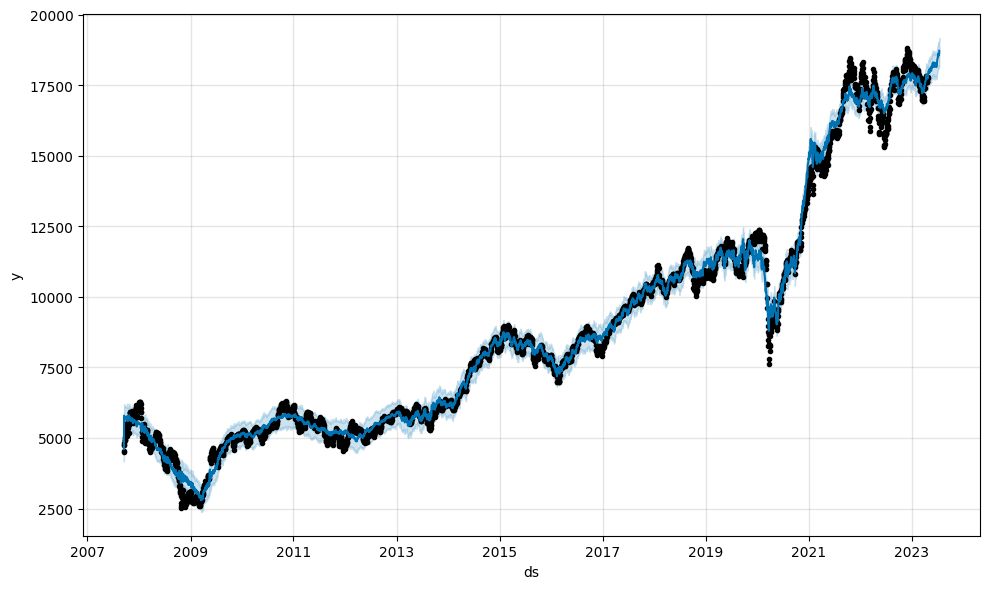

In [12]:
m.plot(forecast);

In [12]:
data = data.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')
data = data.drop("index",axis=1)

In [13]:
#get some variables
prophet_variables = forecast.loc[:, ["trend", "weekly",  "multiplicative_terms","trend_upper","trend_lower"]]
df_xgb = pd.concat([data, prophet_variables], axis = 1)
df_xgb.head(1)

,Date,Open,High,Low,Close,Volume,ds,y,volume_adi,volume_obv,...,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,trend,weekly,multiplicative_terms,trend_upper,trend_lower
0,2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,0,2007-09-17,4494.649902,-0.0,0,...,0.0,4494.649902,-50.000411,0.0,0.0,7282.582125,566.346317,0.0,7282.582125,7282.582125


In [14]:
df_xgb  = add_all_ta_features(df_xgb, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)


In [15]:
    
non_stationaries = []
for col in df_xgb.columns:
    if col != "multiplicative_terms" and col != "Date" and col != "ds" :
        #print(col)
        dftest = adfuller(df_xgb[col].values)
        p_value = dftest[1]
        t_test = dftest[0] < dftest[4]["1%"]
        if p_value > 0.05 or not t_test:
            non_stationaries.append(col)
print(f"Non-Stationary Features Found: {len(non_stationaries)}")

Non-Stationary Features Found: 36


In [16]:
df_stationary = df_xgb.copy()

df_stationary = df_stationary.drop(columns=["Date","ds"])
df_stationary

,Open,High,Low,Close,Volume,y,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,trend,weekly,multiplicative_terms,trend_upper,trend_lower
0,4518.450195,4549.049805,4482.850098,4494.649902,0,4494.649902,-0.000000e+00,0,0.000000,0.000000e+00,...,0.000000,4494.649902,-50.000411,0.000000,0.000000,7282.582125,566.346317,0.0,7282.582125,7282.582125
1,4494.100098,4551.799805,4481.549805,4546.200195,0,4546.200195,0.000000e+00,0,0.000000,0.000000e+00,...,0.000000,4516.715946,1.146926,1.140398,1.146926,7280.438893,566.452476,0.0,7280.438893,7280.438893
2,4550.250000,4739.000000,4550.250000,4732.350098,0,4732.350098,0.000000e+00,0,0.000000,0.000000e+00,...,0.000000,4605.963404,4.094626,4.013017,5.288514,7278.295661,565.728648,0.0,7278.295661,7278.295661
3,4734.850098,4760.850098,4721.149902,4747.549805,0,4747.549805,0.000000e+00,0,0.000000,0.000000e+00,...,0.000000,4664.368713,0.321187,0.320673,5.626687,7276.152429,575.470236,0.0,7276.152429,7276.152429
4,4752.950195,4855.700195,4733.700195,4837.549805,0,4837.549805,0.000000e+00,0,0.000000,0.000000e+00,...,0.000000,4733.773643,1.895715,1.877970,7.629068,7274.009197,556.782520,0.0,7274.009197,7274.009197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,19497.449219,19507.699219,19372.349609,19374.300781,0,19374.300781,3.615614e+07,60413400,0.247359,4.485237e+06,...,-18.380312,19295.914103,-0.081479,-0.081512,331.052500,9453.168474,565.728648,0.0,9529.441466,9411.482166
3879,19495.199219,19567.000000,19385.800781,19413.750000,0,19413.750000,3.615614e+07,60413400,0.226854,3.844489e+06,...,-19.041852,19298.947910,0.203616,0.203409,331.930193,9453.782972,575.470236,0.0,9536.881963,9410.510017
3880,19493.449219,19595.349609,19433.500000,19564.500000,0,19564.500000,3.615614e+07,60413400,0.281848,3.295276e+06,...,-19.197383,19312.443903,0.776511,0.773512,335.284181,9454.397471,556.782520,0.0,9542.301282,9405.828237
3881,19493.449219,19595.349609,19433.500000,19564.500000,291200,19564.500000,3.633633e+07,60704600,0.282011,2.824522e+06,...,-1.257535,19324.528527,0.000000,0.000000,335.284181,9454.397471,556.782520,0.0,9547.860809,9401.070193


In [17]:
df_stationary[non_stationaries] = df_stationary[non_stationaries].pct_change()

#XGBoost preparation

In [18]:
#create training and test set
test_days = 360
training_set = df_xgb.iloc[:-test_days,:]
test_set = df_xgb.iloc[-test_days:,:]


In [44]:
training_set

,Date,Open,High,Low,Close,Volume,ds,y,volume_adi,volume_obv,...,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,trend,weekly,multiplicative_terms,trend_upper,trend_lower
ds,,,,,,,,,,,,,,,,,,,,,
2007-09-17,2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,0,2007-09-17,4494.649902,-0.000000e+00,0,...,0.000000,4494.649902,-50.000411,0.000000,0.000000,7282.582125,566.346317,0.0,7282.582125,7282.582125
2007-09-18,2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,0,2007-09-18,4546.200195,0.000000e+00,0,...,0.000000,4516.715946,1.146926,1.140398,1.146926,7280.438893,566.452476,0.0,7280.438893,7280.438893
2007-09-19,2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,0,2007-09-19,4732.350098,0.000000e+00,0,...,0.000000,4605.963404,4.094626,4.013017,5.288514,7278.295661,565.728648,0.0,7278.295661,7278.295661
2007-09-20,2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,0,2007-09-20,4747.549805,0.000000e+00,0,...,0.000000,4664.368713,0.321187,0.320673,5.626687,7276.152429,575.470236,0.0,7276.152429,7276.152429
2007-09-21,2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,0,2007-09-21,4837.549805,0.000000e+00,0,...,0.000000,4733.773643,1.895715,1.877970,7.629068,7274.009197,556.782520,0.0,7274.009197,7274.009197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,2022-01-31,17301.050781,17410.000000,17264.150391,17339.849609,321700,2022-01-31,17339.849609,2.821675e+07,58978800,...,4.200475,17490.482243,1.391072,1.381485,285.788660,9129.327977,566.346317,0.0,9129.327977,9129.327977
2022-02-01,2022-02-01,17529.449219,17622.400391,17244.550781,17576.849609,386400,2022-02-01,17576.849609,2.850998e+07,59365200,...,4.442907,17497.827764,1.366794,1.357537,291.061595,9129.942475,566.452476,0.0,9129.942475,9129.942475
2022-02-02,2022-02-02,17706.199219,17794.599609,17674.800781,17780.000000,271200,2022-02-02,17780.000000,2.871508e+07,59636400,...,1.935797,17505.747004,1.155784,1.149156,295.581422,9130.556973,565.728648,0.0,9130.556973,9130.556973


In [19]:
train_y_c = []
for i in range(0,len(training_set)):
    if training_set.iloc[i].Open > training_set.iloc[i].Close:
        train_y_c.append(0)
    else:
        train_y_c.append(1)



In [20]:
test_y_c = []
for j in range(0,len(test_set)):
    if test_set.iloc[j].Open > test_set.iloc[j].Close:
        test_y_c.append(0)
    else:
        test_y_c.append(1)
        


In [21]:
#isolate X and y
y_train = train_y_c
y_test = test_y_c 

X_train = training_set.iloc[:, 2:]

X_test = test_set.iloc[:, 2:]


In [22]:
X_train = X_train.drop(columns=["ds"])
X_test = X_test.drop(columns=["ds"])

In [23]:
import xgboost as xgb


In [24]:
model_xgboost = xgb.XGBClassifier(learning_rate=0.1,
                                      min_child_weight=1,
                                      gamma=0,
                                      max_depth=5,
                                      n_estimators=5000,
                                      subsample=0.5,
                                      colsample_bytree=0.5,
                                      eval_metric='auc',
                                      verbosity=1)


In [26]:
#y_train_pred = model_xgboost.predict_proba(X_train)[:,1]
#y_valid_pred = model_xgboost.predict_proba(X_test)[:,1]

#print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
 #                                                   roc_auc_score(y_test, y_valid_pred)))

In [25]:
learning_rate_list = [0.02, 0.01]
max_depth_list = [2, 3, ]
n_estimators_list = [1000,  3000]
colsample_bytree = [ 0.5, 1]
sample_tree = [ 0.8, 1]
min_child_weight = [0.8,1]

params_dict = {"learning_rate": learning_rate_list,
               "max_depth": max_depth_list,
               "n_estimators": n_estimators_list,
               # "colsample_bytree" : colsample_bytree,
               #"subsample" :  sample_tree,
               "min_child_weight" :min_child_weight
              }

num_combinations = 1
for v in params_dict.values(): num_combinations *= len(v) 

print(num_combinations)
params_dict


16


{'learning_rate': [0.02, 0.01],
 'max_depth': [2, 3],
 'n_estimators': [1000, 3000],
 'min_child_weight': [0.8, 1]}

In [26]:
def my_roc_auc_score(model, X, y): return roc_auc_score(y, model.predict_proba(X)[:,1])

model_xgboost_hp = GridSearchCV(estimator=xgb.XGBClassifier(
                                                            eval_metric='auc',
                                                                use_label_encoder=False),
                                param_grid=params_dict,
                                cv=2,
                                scoring=my_roc_auc_score,
                                return_train_score=True,
                                verbose=4)

model_xgboost_hp.fit(X_train, y_train)

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV 1/2] END learning_rate=0.02, max_depth=2, min_child_weight=0.8, n_estimators=1000;, score=(train=0.977, test=0.945) total time=   5.9s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.02, max_depth=2, min_child_weight=0.8, n_estimators=1000;, score=(train=0.987, test=0.904) total time=   5.4s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.02, max_depth=2, min_child_weight=0.8, n_estimators=3000;, score=(train=0.999, test=0.944) total time=  19.1s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.02, max_depth=2, min_child_weight=0.8, n_estimators=3000;, score=(train=0.999, test=0.893) total time=  18.1s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.02, max_depth=2, min_child_weight=1, n_estimators=1000;, score=(train=0.977, test=0.945) total time=   7.3s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.02, max_depth=2, min_child_weight=1, n_estimators=1000;, score=(train=0.987, test=0.904) total time=   6.7s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.02, max_depth=2, min_child_weight=1, n_estimators=3000;, score=(train=0.999, test=0.944) total time=  29.8s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.02, max_depth=2, min_child_weight=1, n_estimators=3000;, score=(train=0.999, test=0.894) total time=  20.3s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.02, max_depth=3, min_child_weight=0.8, n_estimators=1000;, score=(train=0.996, test=0.944) total time=   9.2s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.02, max_depth=3, min_child_weight=0.8, n_estimators=1000;, score=(train=0.998, test=0.899) total time=   8.8s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.02, max_depth=3, min_child_weight=0.8, n_estimators=3000;, score=(train=1.000, test=0.946) total time=  28.3s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.02, max_depth=3, min_child_weight=0.8, n_estimators=3000;, score=(train=1.000, test=0.895) total time=  25.4s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=1000;, score=(train=0.996, test=0.944) total time=  10.2s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=1000;, score=(train=0.998, test=0.903) total time=   8.4s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=3000;, score=(train=1.000, test=0.946) total time=  32.8s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=3000;, score=(train=1.000, test=0.897) total time=  25.4s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.01, max_depth=2, min_child_weight=0.8, n_estimators=1000;, score=(train=0.961, test=0.948) total time=   6.4s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.01, max_depth=2, min_child_weight=0.8, n_estimators=1000;, score=(train=0.976, test=0.909) total time=   6.6s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.01, max_depth=2, min_child_weight=0.8, n_estimators=3000;, score=(train=0.987, test=0.943) total time=  19.8s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.01, max_depth=2, min_child_weight=0.8, n_estimators=3000;, score=(train=0.993, test=0.902) total time=  18.1s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=1000;, score=(train=0.961, test=0.948) total time=   7.0s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=1000;, score=(train=0.976, test=0.909) total time=   6.0s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=3000;, score=(train=0.987, test=0.944) total time=  20.2s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=3000;, score=(train=0.993, test=0.902) total time=  17.4s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.01, max_depth=3, min_child_weight=0.8, n_estimators=1000;, score=(train=0.982, test=0.943) total time=   9.7s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.01, max_depth=3, min_child_weight=0.8, n_estimators=1000;, score=(train=0.989, test=0.902) total time=   8.6s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.01, max_depth=3, min_child_weight=0.8, n_estimators=3000;, score=(train=1.000, test=0.946) total time=  28.3s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.01, max_depth=3, min_child_weight=0.8, n_estimators=3000;, score=(train=1.000, test=0.898) total time=  26.1s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=1000;, score=(train=0.982, test=0.942) total time=   9.5s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=1000;, score=(train=0.989, test=0.907) total time=   9.4s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=3000;, score=(train=1.000, test=0.945) total time=  28.7s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=3000;, score=(train=1.000, test=0.902) total time=  26.3s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.02, 0.01], 'max_depth': [2, 3],
                         'min_child_weight': [0.8, 1],
                         'n_estimators': [1000, 3000]},
             return_train_score=True,
             scoring=<function my_roc_auc_score at 0x7fa32848a040>, verbose=4)

In [27]:
df_cv_results = pd.DataFrame(model_xgboost_hp.cv_results_)
df_cv_results = df_cv_results[['rank_test_score','mean_test_score','mean_train_score',
                               'param_learning_rate', 'param_max_depth', 'param_n_estimators']]
df_cv_results.sort_values(by='rank_test_score', inplace=True)
df_cv_results

,rank_test_score,mean_test_score,mean_train_score,param_learning_rate,param_max_depth,param_n_estimators
8,1,0.928584,0.968516,0.01,2,1000
10,2,0.928565,0.968437,0.01,2,1000
2,3,0.924743,0.982109,0.02,2,1000
14,4,0.924657,0.985170,0.01,3,1000
0,5,0.924339,0.982095,0.02,2,1000
15,6,0.923574,0.999746,0.01,3,3000
6,7,0.923361,0.996946,0.02,3,1000
9,8,0.922711,0.989971,0.01,2,3000
11,9,0.922678,0.989864,0.01,2,3000
12,10,0.922249,0.985465,0.01,3,1000


Text(0.5, 1.0, 'Performance wrt # of Trees and Depth')

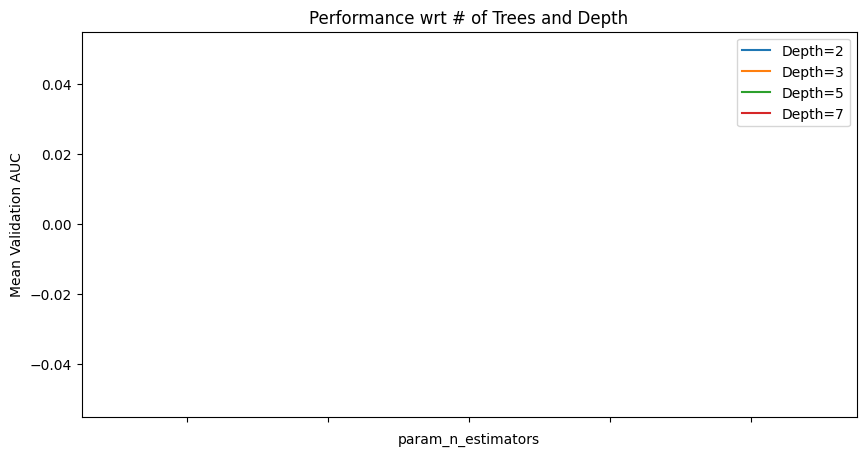

In [28]:
# First sort by number of estimators as that would be x-axis
df_cv_results.sort_values(by='param_n_estimators', inplace=True)

# Find values of AUC for learning rate of 0.05 and different values of depth
lr_d2 = df_cv_results.loc[(df_cv_results['param_learning_rate']==0.05) & (df_cv_results['param_max_depth']==2),:]
lr_d3 = df_cv_results.loc[(df_cv_results['param_learning_rate']==0.05) & (df_cv_results['param_max_depth']==3),:]
lr_d5 = df_cv_results.loc[(df_cv_results['param_learning_rate']==0.05) & (df_cv_results['param_max_depth']==5),:]
lr_d7 = df_cv_results.loc[(df_cv_results['param_learning_rate']==0.05) & (df_cv_results['param_max_depth']==7),:]

# Let us plot now
fig, ax = plt.subplots(figsize=(10,5))
lr_d2.plot(x='param_n_estimators', y='mean_test_score', label='Depth=2', ax=ax)
lr_d3.plot(x='param_n_estimators', y='mean_test_score', label='Depth=3', ax=ax)
lr_d5.plot(x='param_n_estimators', y='mean_test_score', label='Depth=5', ax=ax)
lr_d7.plot(x='param_n_estimators', y='mean_test_score', label='Depth=7', ax=ax)
plt.ylabel('Mean Validation AUC')
plt.title('Performance wrt # of Trees and Depth')

Text(0.5, 1.0, 'Performance wrt learning rate')

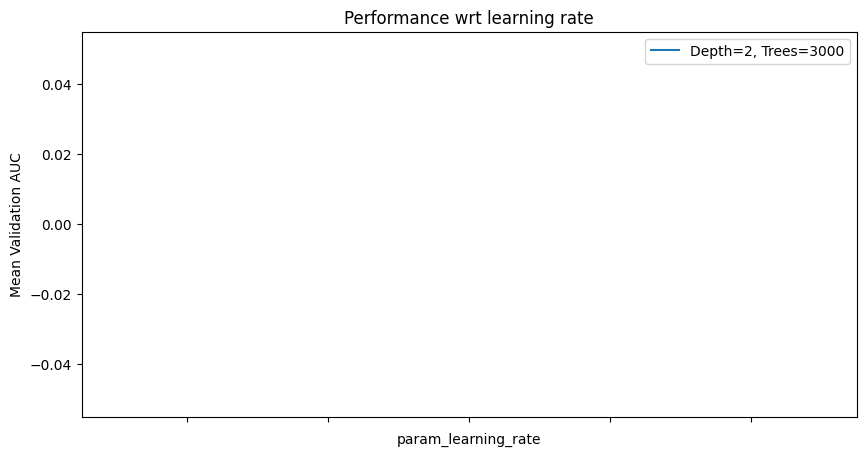

In [29]:
# First sort by learning rate as that would be x-axis
df_cv_results.sort_values(by='param_learning_rate', inplace=True)

# Find values of AUC for learning rate of 0.05 and different values of depth
lr_t3k_d2 = df_cv_results.loc[(df_cv_results['param_n_estimators']==500) & (df_cv_results['param_max_depth']==2),:]

# Let us plot now
fig, ax = plt.subplots(figsize=(10,5))
lr_t3k_d2.plot(x='param_learning_rate', y='mean_test_score', label='Depth=2, Trees=3000', ax=ax)
plt.ylabel('Mean Validation AUC')
plt.title('Performance wrt learning rate')

In [30]:
df_cv_results.iloc[-1]

rank_test_score              16
mean_test_score        0.918269
mean_train_score       0.998993
param_learning_rate        0.02
param_max_depth               2
param_n_estimators         3000
Name: 1, dtype: object

In [31]:
test =False
if test == True:
    lr = 0.2
    max_depth = 2
    n_estimators = 2000
    subsample = 1
    colsample_bytree = 1
else:
    lr = df_cv_results.iloc[-1].param_learning_rate
    max_depth = df_cv_results.iloc[-1].param_max_depth
    n_estimators = df_cv_results.iloc[-1].param_n_estimators
    subsample = 1
    colsample_bytree = 1
    

In [32]:
model_xgboost_fin = xgb.XGBClassifier(learning_rate=lr,
                                          max_depth= max_depth,
                                          n_estimators= n_estimators,
                                          subsample= subsample,
                                          colsample_bytree = colsample_bytree,
                                          eval_metric='auc',
                                          verbosity=1,
                                          use_label_encoder=False)

# Passing both training and validation dataset as we want to plot AUC for both
eval_set = [(X_train, y_train),(X_test, y_test)]

model_xgboost_fin.fit(X_train,
                  y_train,
                  early_stopping_rounds=10,
                  eval_set=eval_set,
                  verbose=True)

[0]	validation_0-auc:0.91477	validation_1-auc:0.85705
[1]	validation_0-auc:0.91477	validation_1-auc:0.85705
[2]	validation_0-auc:0.91477	validation_1-auc:0.85705
[3]	validation_0-auc:0.91477	validation_1-auc:0.85705
[4]	validation_0-auc:0.91477	validation_1-auc:0.85705
[5]	validation_0-auc:0.91477	validation_1-auc:0.85705


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-auc:0.91477	validation_1-auc:0.85705
[7]	validation_0-auc:0.91477	validation_1-auc:0.85705
[8]	validation_0-auc:0.91477	validation_1-auc:0.85705
[9]	validation_0-auc:0.91490	validation_1-auc:0.85719
[10]	validation_0-auc:0.91490	validation_1-auc:0.85719
[11]	validation_0-auc:0.91490	validation_1-auc:0.85719
[12]	validation_0-auc:0.91490	validation_1-auc:0.85719
[13]	validation_0-auc:0.91490	validation_1-auc:0.85719
[14]	validation_0-auc:0.92067	validation_1-auc:0.85969
[15]	validation_0-auc:0.92079	validation_1-auc:0.85895
[16]	validation_0-auc:0.92079	validation_1-auc:0.85895
[17]	validation_0-auc:0.92079	validation_1-auc:0.85895
[18]	validation_0-auc:0.92079	validation_1-auc:0.85895
[19]	validation_0-auc:0.92079	validation_1-auc:0.85895
[20]	validation_0-auc:0.92079	validation_1-auc:0.85895
[21]	validation_0-auc:0.92079	validation_1-auc:0.85895
[22]	validation_0-auc:0.92079	validation_1-auc:0.85895
[23]	validation_0-auc:0.92079	validation_1-auc:0.85895
[24]	validatio

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=3000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [33]:
y_train_pred = model_xgboost_fin.predict_proba(X_train)[:,1]
y_valid_pred = model_xgboost_fin.predict_proba(X_test)[:,1]

print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_test, y_valid_pred)))

AUC Train: 0.9207
AUC Valid: 0.8597


AUC Train: 0.8702
AUC Valid: 0.8111


array([0, 1, 1, ..., 1, 0, 0])

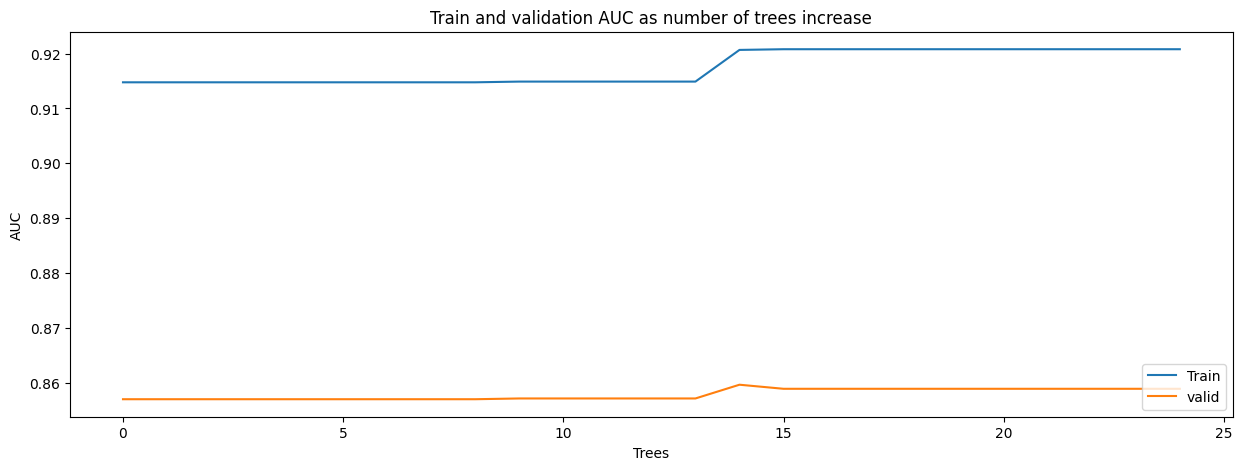

In [34]:
evaluation_results = model_xgboost_fin.evals_result()

# Index into each key to find AUC values for training and validation data after each tree
train_auc_tree = evaluation_results['validation_0']['auc']
valid_auc_tree = evaluation_results['validation_1']['auc']


# Plotting Section
plt.figure(figsize=(15,5))

plt.plot(train_auc_tree, label='Train')
plt.plot(valid_auc_tree, label='valid')

plt.title("Train and validation AUC as number of trees increase")
plt.xlabel("Trees")
plt.ylabel("AUC")
plt.legend(loc='lower right')
plt.show()

In [35]:
df_var_imp = pd.DataFrame({"Variable": X_test.columns,
                           "Importance": model_xgboost_fin.feature_importances_}) \
                        .sort_values(by='Importance', ascending=False)
df_var_imp[:20]

,Variable,Importance
88,others_dr,1.0
0,High,0.0
60,trend_cci,0.0
69,trend_psar_down_indicator,0.0
68,trend_psar_up_indicator,0.0
67,trend_psar_down,0.0
66,trend_psar_up,0.0
65,trend_aroon_ind,0.0
64,trend_aroon_down,0.0
63,trend_aroon_up,0.0


In [36]:
#Visualization
training_set.index = training_set.ds
test_set.index = test_set.ds

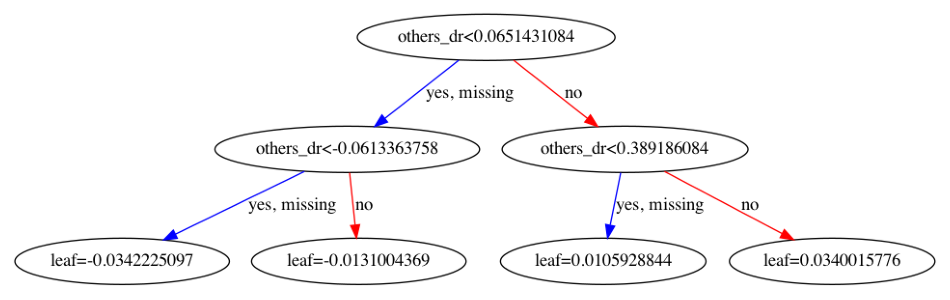

In [37]:
rcParams["figure.figsize"] = 100, 50
dir(model_xgboost_fin)
tree_index = 0  # Index of the tree you want to plot
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_tree(model_xgboost_fin, num_trees=tree_index, ax=ax)
plt.show()

In [40]:
# Save the trained model to a file

with open('../TrainedModel/xg/{}_model_2.pkl'.format(symbol), 'wb') as f:
    pickle.dump(model_xgboost_fin, f)

In [41]:
# Save the trained model to a file

with open('../TrainedModel/xg/{}_model_phrophet.pkl'.format(symbol), 'wb') as f:
    pickle.dump(m, f)